In [1]:
import pandas as pd
from aeon.datasets import load_from_tsf_file #numpy 버전을 aeon에 맞춰 설치하여야 함: 2.0.0 이하, 최초 가상환경 설정 시 pip install aeon으로 해결 가능 혹은 pip install numpy=2.0.0
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl
df = load_from_tsf_file('./dataset/m4_hourly_dataset.tsf')
df

(    series_name     start_timestamp  \
 0            T1 2015-07-01 12:00:00   
 1            T2 2015-07-01 12:00:00   
 2            T3 2015-07-01 12:00:00   
 3            T4 2015-07-01 12:00:00   
 4            T5 2015-07-01 12:00:00   
 ..          ...                 ...   
 409        T410 2017-01-01 12:00:00   
 410        T411 2017-01-01 12:00:00   
 411        T412 2017-01-01 12:00:00   
 412        T413 2017-06-12 12:00:00   
 413        T414 2017-04-27 12:00:00   
 
                                           series_value  
 0    [605.0, 586.0, 586.0, 559.0, 511.0, 443.0, 422...  
 1    [3124.0, 2990.0, 2862.0, 2809.0, 2544.0, 2201....  
 2    [1828.0, 1806.0, 1897.0, 1750.0, 1679.0, 1620....  
 3    [6454.0, 6324.0, 6075.0, 5949.0, 5858.0, 5579....  
 4    [4263.0, 4297.0, 4236.0, 4080.0, 3883.0, 3672....  
 ..                                                 ...  
 409  [153.0, 196.0, 163.0, 131.0, 82.0, 53.0, 57.0,...  
 410  [24.0, 30.0, 22.0, 14.0, 19.0, 20.0, 24.0, 45...

In [2]:
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
df[0]

,series_name,start_timestamp,series_value
0,T1,2015-07-01 12:00:00,"[605.0, 586.0, 586.0, 559.0, 511.0, 443.0, 422..."
1,T2,2015-07-01 12:00:00,"[3124.0, 2990.0, 2862.0, 2809.0, 2544.0, 2201...."
2,T3,2015-07-01 12:00:00,"[1828.0, 1806.0, 1897.0, 1750.0, 1679.0, 1620...."
3,T4,2015-07-01 12:00:00,"[6454.0, 6324.0, 6075.0, 5949.0, 5858.0, 5579...."
4,T5,2015-07-01 12:00:00,"[4263.0, 4297.0, 4236.0, 4080.0, 3883.0, 3672...."
...,...,...,...
409,T410,2017-01-01 12:00:00,"[153.0, 196.0, 163.0, 131.0, 82.0, 53.0, 57.0,..."
410,T411,2017-01-01 12:00:00,"[24.0, 30.0, 22.0, 14.0, 19.0, 20.0, 24.0, 45...."
411,T412,2017-01-01 12:00:00,"[19.0, 30.0, 12.0, 16.0, 13.0, 15.0, 15.0, 21...."
412,T413,2017-06-12 12:00:00,"[21.0, 16.0, 17.0, 19.0, 16.0, 22.0, 21.0, 15...."


In [4]:
df[1]

'''
	•	Metadata
	•	frequency: "hourly" → 데이터가 시간 단위로 수집됨.
	•	forecast_horizon: 48 → 48시간 (2일) 후까지 예측이 필요함.
	•	contain_missing_values: False → 결측값 없음.
	•	contain_equal_length: False → 모든 시계열의 길이가 다름.
'''

'\n\t•\tMetadata\n\t•\tfrequency: "hourly" → 데이터가 시간 단위로 수집됨.\n\t•\tforecast_horizon: 48 → 48시간 (2일) 후까지 예측이 필요함.\n\t•\tcontain_missing_values: False → 결측값 없음.\n\t•\tcontain_equal_length: False → 모든 시계열의 길이가 다름.\n'

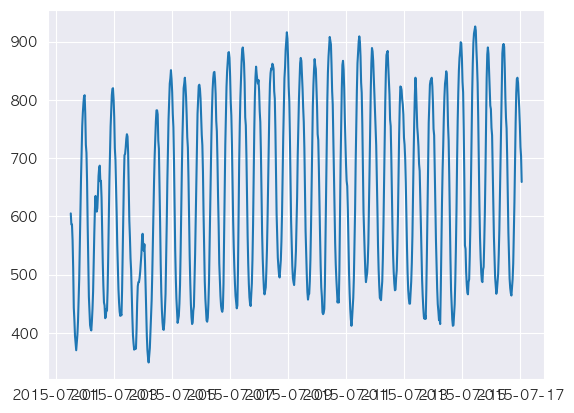

In [5]:
ts = pd.Series(df[0]['series_value'][0], pd.date_range(df[0]['start_timestamp'][0], periods=len(df[0]['series_value'][0]), freq='0.5h'))

plt.plot(ts)
plt.show()

In [6]:
print(type(ts))  # ts의 타입 확인

<class 'pandas.core.series.Series'>


### domain 확보를 위한 csv 파일 생성

- M4-info.csv에서 각 Frequency 별로 domain (SP)가 추가된 파일 생성

In [7]:
import pandas as pd

# M4-info.csv 파일 로드
file_path = "./dataset/M4-info.csv"  # 실제 경로로 변경하세요
df = pd.read_csv(file_path)

# SP (Seasonal Periods) 컬럼이 존재하는지 확인
if 'SP' not in df.columns:
    raise ValueError("M4-info.csv 파일에서 'SP' 컬럼을 찾을 수 없습니다.")

# SP 컬럼의 고유값 확인
unique_sp_values = df['SP'].dropna().unique()
print("고유한 SP 값들:", unique_sp_values)

# SP 값별로 파일 저장
output_dir = "./dataset/SP_filtered/"
import os
os.makedirs(output_dir, exist_ok=True)  # 출력 디렉토리 생성

for sp in unique_sp_values:
    # SP 값이 해당하는 데이터만 필터링
    df_filtered = df[df['SP'] == sp]

    # 파일명 설정 (예: M4_SP_12.csv)
    output_file = f"{output_dir}M4_SP_{sp}.csv"

    # CSV 파일로 저장
    df_filtered.to_csv(output_file, index=False)
    print(f"파일 저장됨: {output_file}")

print("\n모든 SP별 파일 저장 완료!")

고유한 SP 값들: ['Yearly' 'Quarterly' 'Monthly' 'Weekly' 'Daily' 'Hourly']
파일 저장됨: ./dataset/SP_filtered/M4_SP_Yearly.csv
파일 저장됨: ./dataset/SP_filtered/M4_SP_Quarterly.csv
파일 저장됨: ./dataset/SP_filtered/M4_SP_Monthly.csv
파일 저장됨: ./dataset/SP_filtered/M4_SP_Weekly.csv
파일 저장됨: ./dataset/SP_filtered/M4_SP_Daily.csv
파일 저장됨: ./dataset/SP_filtered/M4_SP_Hourly.csv

모든 SP별 파일 저장 완료!


### 기존 데이터셋의 tsf 파일에 추가한 csv 파일에서 SP 데이터를 추가

1.	M4_SP_Hourly.csv 데이터 전처리
- ./dataset/SP_filtered/M4_SP_{frequency}.csv 파일에 있는 'M4id' 컬럼명을 기존 tsf와 동일한 'series_name'으로 변경

2.	TSF 데이터 로드
- df_tsf를 load_from_tsf_file()로 로드.
	
3.	series_name 값 변환
- ./dataset/m4_{frequency}_dataset.tsf 파일에 있는 T1, T2, .. 등의 값을 H1, H2, .. (혹은 D1, D2,.. 파일에 맞게) 변경
	
4.	병합
- series_name을 기준으로 df_tsf와 df_sp를 병합.
	
5.	출력 및 저장
- 병합된 데이터를 출력하고 CSV로 저장.

In [8]:
import pandas as pd
from aeon.datasets import load_from_tsf_file

# 1️⃣ M4_SP_Hourly.csv 파일 로드
sp_file_path = "./dataset/SP_filtered/M4_SP_Weekly.csv"
df_sp = pd.read_csv(sp_file_path)

# 2️⃣ 기존 m4_hourly_dataset.tsf 파일 로드
tsf_file_path = "./dataset/m4_weekly_dataset.tsf"
df_tsf, meta_tsf = load_from_tsf_file(tsf_file_path)

# 데이터 출력
print("===== M4_SP_Hourly.csv Data (처음 5개 행) =====")
print(df_sp.head())

print("\n===== M4 Hourly Dataset (처음 5개 행) =====")
print(df_tsf.head())

print("\n===== TSF 파일 메타데이터 =====")
print(meta_tsf)

===== M4_SP_Hourly.csv Data (처음 5개 행) =====
  M4id category  Frequency  Horizon      SP    StartingDate
0   W1    Other          1       13  Weekly  08-01-75 12:00
1   W2    Other          1       13  Weekly  04-01-84 12:00
2   W3    Other          1       13  Weekly  06-01-75 12:00
3   W4    Other          1       13  Weekly  07-01-67 12:00
4   W5    Other          1       13  Weekly  08-02-86 12:00

===== M4 Hourly Dataset (처음 5개 행) =====
  series_name     start_timestamp  \
0          T1 1975-01-08 12:00:00   
1          T2 1984-01-04 12:00:00   
2          T3 1975-01-06 12:00:00   
3          T4 1967-01-07 12:00:00   
4          T5 1986-02-08 12:00:00   

                                        series_value  
0  [1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1...  
1  [195.928, 194.796, 192.71, 190.288, 188.77, 18...  
2  [258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264...  
3  [3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760....  
4  [4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330....  

=

## 병합 파일 생성

### Hourly

In [9]:
import pandas as pd
from aeon.datasets import load_from_tsf_file

# 1️⃣ M4_SP_Hourly.csv 파일 로드 (컬럼명 변경)
sp_file_path = "./dataset/SP_filtered/M4_SP_Hourly.csv"
df_sp = pd.read_csv(sp_file_path)
df_sp.rename(columns={'M4id': 'series_name'}, inplace=True)  # 컬럼명 변경

# 2️⃣ 기존 m4_hourly_dataset.tsf 파일 로드
tsf_file_path = "./dataset/m4_hourly_dataset.tsf"
df_tsf, meta_tsf = load_from_tsf_file(tsf_file_path)

# 3️⃣ df_tsf의 'series_name' 값에서 'T'를 'Q'로 변경
df_tsf['series_name'] = df_tsf['series_name'].str.replace('T', 'H')

# 4️⃣ 두 데이터프레임 병합 (series_name 기준)
df_merged = pd.merge(df_tsf, df_sp, on='series_name', how='left')

# 5️⃣ 병합된 데이터에서 series_value 컬럼을 일반 리스트로 변환 (각 요소를 float로 변환)
def convert_to_list(x):
    # 만약 x에 tolist() 메서드가 있다면 사용하고, 그렇지 않으면 그대로 반환
    try:
        lst = x.tolist()
    except AttributeError:
        lst = x
    return [float(v) for v in lst]

df_merged['series_value'] = df_merged['series_value'].apply(convert_to_list)

# 6️⃣ 병합된 데이터 출력
print("\n===== 병합된 데이터 (처음 5개 행) =====")
print(df_merged.head())

# 7️⃣ 병합된 데이터 저장 (CSV)
output_path = "./dataset/final_dataset/M4_Hourly_Merged.csv"
df_merged.to_csv(output_path, index=False)
print(f"\n병합된 데이터가 '{output_path}'에 저장되었습니다.")


===== 병합된 데이터 (처음 5개 행) =====
  series_name     start_timestamp  \
0          H1 2015-07-01 12:00:00   
1          H2 2015-07-01 12:00:00   
2          H3 2015-07-01 12:00:00   
3          H4 2015-07-01 12:00:00   
4          H5 2015-07-01 12:00:00   

                                        series_value category  Frequency  \
0  [605.0, 586.0, 586.0, 559.0, 511.0, 443.0, 422...    Other         24   
1  [3124.0, 2990.0, 2862.0, 2809.0, 2544.0, 2201....    Other         24   
2  [1828.0, 1806.0, 1897.0, 1750.0, 1679.0, 1620....    Other         24   
3  [6454.0, 6324.0, 6075.0, 5949.0, 5858.0, 5579....    Other         24   
4  [4263.0, 4297.0, 4236.0, 4080.0, 3883.0, 3672....    Other         24   

   Horizon      SP    StartingDate  
0       48  Hourly  01-07-15 12:00  
1       48  Hourly  01-07-15 12:00  
2       48  Hourly  01-07-15 12:00  
3       48  Hourly  01-07-15 12:00  
4       48  Hourly  01-07-15 12:00  

병합된 데이터가 './dataset/final_dataset/M4_Hourly_Merged.csv'에 저장되었습니다.


In [10]:
import pandas as pd
import ast
import numpy as np

# CSV 파일 로드
df = pd.read_csv("./dataset/final_dataset/M4_Hourly_Merged.csv")

# series_value 컬럼을 안전하게 리스트로 변환하는 함수
def safe_literal_eval(val):
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

# series_value 컬럼을 리스트로 변환
df['series_value'] = df['series_value'].apply(safe_literal_eval)

# 각 시계열의 길이를 계산하여 새로운 컬럼 'series_length' 생성
df['series_length'] = df['series_value'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# SP 정보 추출 (고유한 SP 값 확인)
sp_info = ", ".join(map(str, df['SP'].dropna().unique()))

# 각 카테고리별(예: Macro, Finance 등) 시계열 길이 통계 계산
grouped_stats = df.groupby('category')['series_length'].agg(['count', 'min', 'max', 'mean', 'median'])
print(f"===== 각 카테고리별 시계열 길이 통계 (SP: {sp_info}) =====")
print(grouped_stats)

# 각 카테고리별 고유한 시계열 길이 종류 확인
unique_lengths = df.groupby('category')['series_length'].apply(lambda x: sorted(x.dropna().unique()))
print(f"\n===== 각 카테고리별 고유 시계열 길이 (SP: {sp_info}) =====")
print(unique_lengths)

===== 각 카테고리별 시계열 길이 통계 (SP: Hourly) =====
          count  min   max        mean  median
category                                      
Other       414  748  1008  901.864734  1008.0

===== 각 카테고리별 고유 시계열 길이 (SP: Hourly) =====
category
Other    [748, 1008]
Name: series_length, dtype: object


### Daily

In [11]:
import pandas as pd
from aeon.datasets import load_from_tsf_file

# 1️⃣ M4_SP_Daily.csv 파일 로드 (컬럼명 변경)
sp_file_path = "./dataset/SP_filtered/M4_SP_Daily.csv"
df_sp = pd.read_csv(sp_file_path)
df_sp.rename(columns={'M4id': 'series_name'}, inplace=True)  # 컬럼명 변경

# 2️⃣ 기존 m4_daily_dataset.tsf 파일 로드
tsf_file_path = "./dataset/m4_daily_dataset.tsf"
df_tsf, meta_tsf = load_from_tsf_file(tsf_file_path)

# 3️⃣ df_tsf의 'series_name' 값에서 'T'를 'Q'로 변경
df_tsf['series_name'] = df_tsf['series_name'].str.replace('T', 'D')

# 4️⃣ 두 데이터프레임 병합 (series_name 기준)
df_merged = pd.merge(df_tsf, df_sp, on='series_name', how='left')

# 5️⃣ 병합된 데이터에서 series_value 컬럼을 일반 리스트로 변환 (각 요소를 float로 변환)
def convert_to_list(x):
    # 만약 x에 tolist() 메서드가 있다면 사용하고, 그렇지 않으면 그대로 반환
    try:
        lst = x.tolist()
    except AttributeError:
        lst = x
    return [float(v) for v in lst]

df_merged['series_value'] = df_merged['series_value'].apply(convert_to_list)

# 6️⃣ 병합된 데이터 출력
print("\n===== 병합된 데이터 (처음 5개 행) =====")
print(df_merged.head())

# 7️⃣ 병합된 데이터 저장 (CSV)
output_path = "./dataset/final_dataset/M4_Daily_Merged.csv"
df_merged.to_csv(output_path, index=False)
print(f"\n병합된 데이터가 '{output_path}'에 저장되었습니다.")


===== 병합된 데이터 (처음 5개 행) =====
  series_name     start_timestamp  \
0          D1 1994-01-03 12:00:00   
1          D2 1995-01-02 12:00:00   
2          D3 2006-01-05 12:00:00   
3          D4 1996-05-30 12:00:00   
4          D5 1997-01-03 12:00:00   

                                        series_value category  Frequency  \
0  [1017.1, 1019.3, 1017.0, 1019.2, 1018.7, 1015....    Macro          1   
1  [2793.7, 2793.8, 2803.7, 2805.8, 2802.3, 2795....    Macro          1   
2  [1091.3, 1088.5, 1085.7, 1082.9, 1080.1, 1077....    Macro          1   
3  [1092.0, 1078.0, 1064.0, 1050.0, 1036.0, 1022....    Macro          1   
4  [2938.63, 2956.44, 2964.41, 2972.41, 3014.97, ...    Macro          1   

   Horizon     SP    StartingDate  
0       14  Daily  03-01-94 12:00  
1       14  Daily  02-01-95 12:00  
2       14  Daily  05-01-06 12:00  
3       14  Daily  30-05-96 12:00  
4       14  Daily  03-01-97 12:00  

병합된 데이터가 './dataset/final_dataset/M4_Daily_Merged.csv'에 저장되었습니다.


In [12]:
import pandas as pd
import ast
import numpy as np

# CSV 파일 로드
df = pd.read_csv("./dataset/final_dataset/M4_Daily_Merged.csv")

# series_value 컬럼을 안전하게 리스트로 변환하는 함수
def safe_literal_eval(val):
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

# series_value 컬럼을 리스트로 변환
df['series_value'] = df['series_value'].apply(safe_literal_eval)

# 각 시계열의 길이를 계산하여 새로운 컬럼 'series_length' 생성
df['series_length'] = df['series_value'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# SP 정보 추출 (고유한 SP 값 확인)
sp_info = ", ".join(map(str, df['SP'].dropna().unique()))

# 각 카테고리별(예: Macro, Finance 등) 시계열 길이 통계 계산
grouped_stats = df.groupby('category')['series_length'].agg(['count', 'min', 'max', 'mean', 'median'])
print(f"===== 각 카테고리별 시계열 길이 통계 (SP: {sp_info}) =====")
print(grouped_stats)

# 각 카테고리별 고유한 시계열 길이 종류 확인
unique_lengths = df.groupby('category')['series_length'].apply(lambda x: sorted(x.dropna().unique()))
print(f"\n===== 각 카테고리별 고유 시계열 길이 (SP: {sp_info}) =====")
print(unique_lengths)

===== 각 카테고리별 시계열 길이 통계 (SP: Daily) =====
             count   min   max         mean  median
category                                           
Demographic     10  1054  4454  4043.100000  4329.0
Finance       1559   107  8533  3263.664529  4210.0
Industry       422   113  4569   560.215640   316.0
Macro          127   111  1020   665.511811   687.0
Micro         1476   112  4754  2929.510840  3712.0
Other          633   109  9933   395.676145   281.0

===== 각 카테고리별 고유 시계열 길이 (SP: Daily) =====
category
Demographic                             [1054, 4329, 4412, 4454]
Finance        [107, 119, 121, 125, 126, 128, 129, 130, 131, ...
Industry       [113, 117, 122, 125, 126, 135, 139, 149, 157, ...
Macro          [111, 144, 145, 148, 157, 165, 168, 169, 170, ...
Micro          [112, 119, 121, 122, 124, 125, 126, 127, 128, ...
Other          [109, 111, 114, 117, 122, 124, 125, 126, 127, ...
Name: series_length, dtype: object


### Quarterly

In [13]:
import pandas as pd
from aeon.datasets import load_from_tsf_file

# 1️⃣ M4_SP_Quarterly.csv 파일 로드 (컬럼명 변경)
sp_file_path = "./dataset/SP_filtered/M4_SP_Quarterly.csv"
df_sp = pd.read_csv(sp_file_path)
df_sp.rename(columns={'M4id': 'series_name'}, inplace=True)  # 컬럼명 변경

# 2️⃣ 기존 m4_quarterly_dataset.tsf 파일 로드
tsf_file_path = "./dataset/m4_quarterly_dataset.tsf"
df_tsf, meta_tsf = load_from_tsf_file(tsf_file_path)

# 3️⃣ df_tsf의 'series_name' 값에서 'T'를 'Q'로 변경
df_tsf['series_name'] = df_tsf['series_name'].str.replace('T', 'Q')

# 4️⃣ 두 데이터프레임 병합 (series_name 기준)
df_merged = pd.merge(df_tsf, df_sp, on='series_name', how='left')

# 5️⃣ 병합된 데이터에서 series_value 컬럼을 일반 리스트로 변환 (각 요소를 float로 변환)
def convert_to_list(x):
    # 만약 x에 tolist() 메서드가 있다면 사용하고, 그렇지 않으면 그대로 반환
    try:
        lst = x.tolist()
    except AttributeError:
        lst = x
    return [float(v) for v in lst]

df_merged['series_value'] = df_merged['series_value'].apply(convert_to_list)

# 6️⃣ 병합된 데이터 출력
print("\n===== 병합된 데이터 (처음 5개 행) =====")
print(df_merged.head())

# 7️⃣ 병합된 데이터 저장 (CSV)
output_path = "./dataset/final_dataset/M4_Quarterly_Merged.csv"
df_merged.to_csv(output_path, index=False)
print(f"\n병합된 데이터가 '{output_path}'에 저장되었습니다.")


===== 병합된 데이터 (처음 5개 행) =====
  series_name     start_timestamp  \
0          Q1 2005-01-01 12:00:00   
1          Q2 2005-01-01 12:00:00   
2          Q3 2005-01-01 12:00:00   
3          Q4 2005-01-01 12:00:00   
4          Q5 2000-01-01 12:00:00   

                                        series_value category  Frequency  \
0  [7407.4123138155, 7528.5660742987, 7374.709224...    Macro          4   
1  [7552.4546191063, 7541.7745706587, 7466.568336...    Macro          4   
2  [8463.8421931973, 8366.1023091148, 8269.502191...    Macro          4   
3  [8498.9411939739, 8409.9264419862, 8391.441381...    Macro          4   
4  [1835.0, 2322.0, 3059.0, 1883.0, 1896.0, 2060....    Macro          4   

   Horizon         SP    StartingDate  
0        8  Quarterly  01-01-05 12:00  
1        8  Quarterly  01-01-05 12:00  
2        8  Quarterly  01-01-05 12:00  
3        8  Quarterly  01-01-05 12:00  
4        8  Quarterly  01-01-00 12:00  

병합된 데이터가 './dataset/final_dataset/M4_Quarterly_M

In [14]:
import pandas as pd
import ast
import numpy as np

# CSV 파일 로드
df = pd.read_csv("./dataset/final_dataset/M4_Quarterly_Merged.csv")

# series_value 컬럼을 안전하게 리스트로 변환하는 함수
def safe_literal_eval(val):
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

# series_value 컬럼을 리스트로 변환
df['series_value'] = df['series_value'].apply(safe_literal_eval)

# 각 시계열의 길이를 계산하여 새로운 컬럼 'series_length' 생성
df['series_length'] = df['series_value'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# SP 정보 추출 (고유한 SP 값 확인)
sp_info = ", ".join(map(str, df['SP'].dropna().unique()))

# 각 카테고리별(예: Macro, Finance 등) 시계열 길이 통계 계산
grouped_stats = df.groupby('category')['series_length'].agg(['count', 'min', 'max', 'mean', 'median'])
print(f"===== 각 카테고리별 시계열 길이 통계 (SP: {sp_info}) =====")
print(grouped_stats)

# 각 카테고리별 고유한 시계열 길이 종류 확인
unique_lengths = df.groupby('category')['series_length'].apply(lambda x: sorted(x.dropna().unique()))
print(f"\n===== 각 카테고리별 고유 시계열 길이 (SP: {sp_info}) =====")
print(unique_lengths)

===== 각 카테고리별 시계열 길이 통계 (SP: Quarterly) =====
             count  min  max        mean  median
category                                        
Demographic   1858   30  743  100.931109   100.0
Finance       5305   28  746  102.760038   104.0
Industry      4637   28  745  100.239595    81.0
Macro         5315   28  874  105.406397   106.0
Micro         6020   29  745   94.468605    88.0
Other          865   24  709   92.126012    78.0

===== 각 카테고리별 고유 시계열 길이 (SP: Quarterly) =====
category
Demographic    [30, 34, 35, 36, 39, 40, 41, 43, 44, 45, 47, 4...
Finance        [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 4...
Industry       [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...
Macro          [28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...
Micro          [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...
Other          [24, 25, 30, 31, 34, 35, 48, 50, 53, 58, 59, 6...
Name: series_length, dtype: object


### Weekly

In [15]:
import pandas as pd
from aeon.datasets import load_from_tsf_file

# 1️⃣ M4_SP_Weekly.csv 파일 로드 (컬럼명 변경)
sp_file_path = "./dataset/SP_filtered/M4_SP_Weekly.csv"
df_sp = pd.read_csv(sp_file_path)
df_sp.rename(columns={'M4id': 'series_name'}, inplace=True)  # 컬럼명 변경

# 2️⃣ 기존 m4_weekly_dataset.tsf 파일 로드
tsf_file_path = "./dataset/m4_weekly_dataset.tsf"
df_tsf, meta_tsf = load_from_tsf_file(tsf_file_path)

# 3️⃣ df_tsf의 'series_name' 값에서 'T'를 'W'로 변경
df_tsf['series_name'] = df_tsf['series_name'].str.replace('T', 'W')

# 4️⃣ 두 데이터프레임 병합 (series_name 기준)
df_merged = pd.merge(df_tsf, df_sp, on='series_name', how='left')

# 5️⃣ 병합된 데이터에서 series_value 컬럼을 일반 리스트로 변환 (각 요소를 float로 변환)
def convert_to_list(x):
    # 만약 x에 tolist() 메서드가 있다면 사용하고, 그렇지 않으면 그대로 반환
    try:
        lst = x.tolist()
    except AttributeError:
        lst = x
    return [float(v) for v in lst]

df_merged['series_value'] = df_merged['series_value'].apply(convert_to_list)

# 6️⃣ 병합된 데이터 출력
print("\n===== 병합된 데이터 (처음 5개 행) =====")
print(df_merged.head())

# 7️⃣ 병합된 데이터 저장 (CSV)
output_path = "./dataset/final_dataset/M4_Weekly_Merged.csv"
df_merged.to_csv(output_path, index=False)
print(f"\n병합된 데이터가 '{output_path}'에 저장되었습니다.")


===== 병합된 데이터 (처음 5개 행) =====
  series_name     start_timestamp  \
0          W1 1975-01-08 12:00:00   
1          W2 1984-01-04 12:00:00   
2          W3 1975-01-06 12:00:00   
3          W4 1967-01-07 12:00:00   
4          W5 1986-02-08 12:00:00   

                                        series_value category  Frequency  \
0  [1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1...    Other          1   
1  [195.928, 194.796, 192.71, 190.288, 188.77, 18...    Other          1   
2  [258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264...    Other          1   
3  [3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760....    Other          1   
4  [4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330....    Other          1   

   Horizon      SP    StartingDate  
0       13  Weekly  08-01-75 12:00  
1       13  Weekly  04-01-84 12:00  
2       13  Weekly  06-01-75 12:00  
3       13  Weekly  07-01-67 12:00  
4       13  Weekly  08-02-86 12:00  

병합된 데이터가 './dataset/final_dataset/M4_Weekly_Merged.csv'에 저장되었습니다.


In [16]:
import pandas as pd
import ast
import numpy as np

# CSV 파일 로드
df = pd.read_csv("./dataset/final_dataset/M4_Weekly_Merged.csv")

# series_value 컬럼을 안전하게 리스트로 변환하는 함수
def safe_literal_eval(val):
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

# series_value 컬럼을 리스트로 변환
df['series_value'] = df['series_value'].apply(safe_literal_eval)

# 각 시계열의 길이를 계산하여 새로운 컬럼 'series_length' 생성
df['series_length'] = df['series_value'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# SP 정보 추출 (고유한 SP 값 확인)
sp_info = ", ".join(map(str, df['SP'].dropna().unique()))

# 각 카테고리별(예: Macro, Finance 등) 시계열 길이 통계 계산
grouped_stats = df.groupby('category')['series_length'].agg(['count', 'min', 'max', 'mean', 'median'])
print(f"===== 각 카테고리별 시계열 길이 통계 (SP: {sp_info}) =====")
print(grouped_stats)

# 각 카테고리별 고유한 시계열 길이 종류 확인
unique_lengths = df.groupby('category')['series_length'].apply(lambda x: sorted(x.dropna().unique()))
print(f"\n===== 각 카테고리별 고유 시계열 길이 (SP: {sp_info}) =====")
print(unique_lengths)

===== 각 카테고리별 시계열 길이 통계 (SP: Weekly) =====
             count   min   max         mean  median
category                                           
Demographic     24  1615  2609  1658.666667  1615.0
Finance        164   260  2297  1236.835366  1057.0
Industry         6   356  1620   834.333333   755.5
Macro           41   522  1636  1263.512195  1306.0
Micro          112    93  2192   472.687500    93.0
Other           12   470  2610  1598.250000  1616.0

===== 각 카테고리별 고유 시계열 길이 (SP: Weekly) =====
category
Demographic                       [1615, 1616, 1620, 1636, 2609]
Finance        [260, 288, 392, 445, 459, 470, 497, 500, 517, ...
Industry                        [356, 378, 674, 837, 1141, 1620]
Macro          [522, 523, 734, 947, 1019, 1028, 1030, 1037, 1...
Micro          [93, 288, 392, 734, 837, 947, 953, 1057, 1100,...
Other          [470, 947, 1615, 1616, 1636, 1723, 2191, 2192,...
Name: series_length, dtype: object


### Yearly

In [17]:
import pandas as pd
# 파라미터 research cㅊ
# 초기값 설정 -> 도메인 같으면 비슷한 성질
from aeon.datasets import load_from_tsf_file

# 1️⃣ M4_SP_Yearly.csv 파일 로드 (컬럼명 변경)
sp_file_path = "./dataset/SP_filtered/M4_SP_Yearly.csv"
df_sp = pd.read_csv(sp_file_path)
df_sp.rename(columns={'M4id': 'series_name'}, inplace=True)  # 컬럼명 변경

# 2️⃣ 기존 m4_quarterly_dataset.tsf 파일 로드
tsf_file_path = "./dataset/m4_yearly_dataset.tsf"
df_tsf, meta_tsf = load_from_tsf_file(tsf_file_path)

# 3️⃣ df_tsf의 'series_name' 값에서 'T'를 'Q'로 변경
df_tsf['series_name'] = df_tsf['series_name'].str.replace('T', 'Y')

# 4️⃣ 두 데이터프레임 병합 (series_name 기준)
df_merged = pd.merge(df_tsf, df_sp, on='series_name', how='left')

# 5️⃣ 병합된 데이터에서 series_value 컬럼을 일반 리스트로 변환 (각 요소를 float로 변환)
def convert_to_list(x):
    # 만약 x에 tolist() 메서드가 있다면 사용하고, 그렇지 않으면 그대로 반환
    try:
        lst = x.tolist()
    except AttributeError:
        lst = x
    return [float(v) for v in lst]

df_merged['series_value'] = df_merged['series_value'].apply(convert_to_list)

# 6️⃣ 병합된 데이터 출력
print("\n===== 병합된 데이터 (처음 5개 행) =====")
print(df_merged.head())

# 7️⃣ 병합된 데이터 저장 (CSV)
output_path = "./dataset/final_dataset/M4_Yearly_Merged.csv"
df_merged.to_csv(output_path, index=False)
print(f"\n병합된 데이터가 '{output_path}'에 저장되었습니다.")


===== 병합된 데이터 (처음 5개 행) =====
  series_name     start_timestamp  \
0          Y1 1979-01-01 12:00:00   
1          Y2 1979-01-01 12:00:00   
2          Y3 1979-01-01 12:00:00   
3          Y4 1979-01-01 12:00:00   
4          Y5 1979-01-01 12:00:00   

                                        series_value category  Frequency  \
0  [5172.1, 5133.5, 5186.9, 5084.6, 5182.0, 5414....    Macro          1   
1  [2070.0, 2104.0, 2394.0, 1651.0, 1492.0, 1348....    Macro          1   
2  [2760.0, 2980.0, 3200.0, 3450.0, 3670.0, 3850....    Macro          1   
3  [3380.0, 3670.0, 3960.0, 4190.0, 4440.0, 4700....    Macro          1   
4  [1980.0, 2030.0, 2220.0, 2530.0, 2610.0, 2720....    Macro          1   

   Horizon      SP    StartingDate  
0        6  Yearly  01-01-79 12:00  
1        6  Yearly  01-01-79 12:00  
2        6  Yearly  01-01-79 12:00  
3        6  Yearly  01-01-79 12:00  
4        6  Yearly  01-01-79 12:00  

병합된 데이터가 './dataset/final_dataset/M4_Yearly_Merged.csv'에 저장되었습니다.


In [18]:
import pandas as pd
import ast
import numpy as np

# CSV 파일 로드
df = pd.read_csv("./dataset/final_dataset/M4_Yearly_Merged.csv")

# series_value 컬럼을 안전하게 리스트로 변환하는 함수
def safe_literal_eval(val):
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

# series_value 컬럼을 리스트로 변환
df['series_value'] = df['series_value'].apply(safe_literal_eval)

# 각 시계열의 길이를 계산하여 새로운 컬럼 'series_length' 생성
df['series_length'] = df['series_value'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# SP 정보 추출 (고유한 SP 값 확인)
sp_info = ", ".join(map(str, df['SP'].dropna().unique()))

# 각 카테고리별(예: Macro, Finance 등) 시계열 길이 통계 계산
grouped_stats = df.groupby('category')['series_length'].agg(['count', 'min', 'max', 'mean', 'median'])
print(f"===== 각 카테고리별 시계열 길이 통계 (SP: {sp_info}) =====")
print(grouped_stats)

# 각 카테고리별 고유한 시계열 길이 종류 확인
unique_lengths = df.groupby('category')['series_length'].apply(lambda x: sorted(x.dropna().unique()))
print(f"\n===== 각 카테고리별 고유 시계열 길이 (SP: {sp_info}) =====")
print(unique_lengths)

===== 각 카테고리별 시계열 길이 통계 (SP: Yearly) =====
             count  min  max       mean  median
category                                       
Demographic   1088   21  328  40.864890    40.0
Finance       6519   21  827  36.033901    34.0
Industry      3716   21  841  39.308127    35.0
Macro         3903   21  398  35.800922    34.0
Micro         6538   21  766  37.836494    36.0
Other         1236   19  801  37.149676    28.0

===== 각 카테고리별 고유 시계열 길이 (SP: Yearly) =====
category
Demographic    [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...
Finance        [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...
Industry       [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...
Macro          [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...
Micro          [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...
Other          [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...
Name: series_length, dtype: object


### SP 컬럼이 제대로 생성되었는지 확인

In [19]:
import pandas as pd

# 파일 경로|
output_path = "./dataset/final_dataset/M4_Hourly_Merged.csv"

# CSV 파일 로드
df_merged = pd.read_csv(output_path)

# 컬럼명 출력
print("파일의 컬럼명:")
print(df_merged.columns.tolist())

파일의 컬럼명:
['series_name', 'start_timestamp', 'series_value', 'category', 'Frequency', 'Horizon', 'SP', 'StartingDate']


### 클러스터링

In [20]:
pip install tslearn scikit-learn statsmodels numpy pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Domain Clustering 

- Frequency : Quarterly


In [27]:
import numpy as np
import pandas as pd
from collections import defaultdict
import warnings
import ast
warnings.filterwarnings("ignore")

# 필요한 라이브러리 임포트
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler
from pmdarima.arima import ARIMA
from aeon.datasets import load_from_tsf_file

def safe_literal_eval(val):
    """
    주어진 값이 문자열로 되어 있고 '['로 시작하면 ast.literal_eval을 시도하고,
    그렇지 않으면 그대로 반환하는 함수.
    """
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

def grid_search_sarima(time_series, m=4):
    """
    주어진 시계열 데이터에 대해 후보 ARIMA 파라미터 조합에 따른 그리드 서치를 수행하고,
    각 후보 조합과 AIC 값을 출력한 후, 가장 낮은 AIC 값을 가진 파라미터 조합을 반환.
    
    후보 범위:
      - p: 0, 1, 2
      - d: 0, 1
      - q: 0, 1, 2
      - P: 0, 1
      - D: 0, 1
      - Q: 0, 1
      - m: 고정 (여기서는 4)
      
    Returns:
      best_order (tuple), best_seasonal_order (tuple), best_aic (float)
    """
    p_values = [0, 1, 2]
    d_values = [0, 1]
    q_values = [0, 1, 2]
    P_values = [0, 1]
    D_values = [0, 1]
    Q_values = [0, 1]

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            try:
                                model = ARIMA(order=order, seasonal_order=seasonal_order).fit(time_series)
                                candidate_aic = model.aic()
                                print(f"Candidate ARIMA{order}x{seasonal_order} -> AIC: {candidate_aic:.2f}")
                                if candidate_aic < best_aic:
                                    best_aic = candidate_aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except Exception as e:
                                continue
    return best_order, best_seasonal_order, best_aic

# --- 최종 클러스터링 결과에 초기 파라미터를 할당하는 함수 (재사용) ---
def assign_fixed_parameters_to_clusters(cluster_ids, best_order, best_seasonal_order):
    """
    클러스터별로, 미리 선정된 초기 파라미터(best_order, best_seasonal_order)를
    각 군집에 할당하는 함수.
    
    Returns:
      dict: 각 클러스터별 초기 파라미터와 군집에 속한 시계열 ID 목록.
    """
    cluster_params = {}
    for cluster, ids in cluster_ids.items():
        cluster_params[cluster] = {
            'order': best_order,
            'seasonal_order': best_seasonal_order,
            'num_series': len(ids),
            'sample_ids': ids[:5]
        }
    return cluster_params

# =============================================================================
# 실행 코드 블럭: 도메인별 그룹화, 클러스터링, 각 군집별 그리드 서치를 통한 초기 파라미터 선정,
# 그리고 최종 결과 도출
# =============================================================================

# 1. 병합된 데이터 로드 (CSV 파일)
tsf_file_path = "./dataset/final_dataset/M4_Quarterly_Merged.csv"  # CSV 파일 경로
df_q = pd.read_csv(tsf_file_path)

# 2. 병합된 데이터에서 'category' 컬럼을 기준으로 도메인별 그룹화
domain_time_series = defaultdict(dict)
for idx, row in df_q.iterrows():
    category = row['category']  # 예: Macro, Finance 등
    ts_id = row['series_name']
    values = safe_literal_eval(row['series_value'])
    if values is None:
        continue
    domain_time_series[category][ts_id] = (row['start_timestamp'], values)

domain_results = {}
for domain, ts_dict in domain_time_series.items():
    print(f"\n========== 도메인: {domain} ==========")

    # 먼저 도메인 전체에 대해 DTW 기반 클러스터링을 수행하여 군집을 구분
    domain_series = []
    domain_ids = []
    for ts_id, (start_time, values) in ts_dict.items():
        if len(values) >= 8:
            domain_series.append(values)
            domain_ids.append(ts_id)
    domain_initial_length = int(np.median([len(s) for s in domain_series]))
    resampler_domain = TimeSeriesResampler(sz=domain_initial_length)
    X_domain = resampler_domain.fit_transform(domain_series)
    clustering_model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=42, verbose=True)
    y_domain = clustering_model.fit_predict(X_domain)
    clusters = defaultdict(list)
    cluster_ids = defaultdict(list)
    for ts_id, cluster in zip(domain_ids, y_domain):
        clusters[cluster].append(ts_dict[ts_id])
        cluster_ids[cluster].append(ts_id)
    for cluster in clusters:
        print(f"클러스터 {cluster}: {len(clusters[cluster])}개 시계열")

    # 각 군집별로 랜덤 샘플 20개(20개 미만이면 전체)를 선택하여, 
    # grid search를 수행하고 그 결과 중 AIC가 가장 낮은 파라미터를 해당 군집의 초기 파라미터로 결정
    cluster_initial_params = {}  # 각 군집별 초기 파라미터 저장
    for cluster in clusters:
        cluster_data = clusters[cluster]
        id_list = cluster_ids[cluster]
        if len(cluster_data) >= 20:
            sample_indices = np.random.choice(range(len(cluster_data)), size=20, replace=False)
        else:
            sample_indices = list(range(len(cluster_data)))
        print(f"\n클러스터 {cluster}에서 {len(sample_indices)}개 샘플 선택 (전체 {len(cluster_data)}개)")

        best_cluster_aic = np.inf
        best_cluster_order = None
        best_cluster_seasonal_order = None
        # 각 샘플에 대해 grid search 수행
        for idx in sample_indices:
            ts_sample = cluster_data[idx][1]  # (start_timestamp, values)
            print(f"샘플 {id_list[idx]}에 대한 그리드 서치:")
            order_candidate, seasonal_candidate, aic_candidate = grid_search_sarima(ts_sample, m=4)
            print(f"  후보: ARIMA{order_candidate}x{seasonal_candidate} -> AIC: {aic_candidate:.2f}")
            if aic_candidate < best_cluster_aic:
                best_cluster_aic = aic_candidate
                best_cluster_order = order_candidate
                best_cluster_seasonal_order = seasonal_candidate
        print(f"클러스터 {cluster} 최종 초기 파라미터: ARIMA{best_cluster_order}x{best_cluster_seasonal_order} (AIC: {best_cluster_aic:.2f})")
        cluster_initial_params[cluster] = {
            'order': best_cluster_order,
            'seasonal_order': best_cluster_seasonal_order,
            'best_aic': best_cluster_aic
        }

    # 최종적으로, 각 클러스터에 대해 선정된 초기 파라미터를 할당
    fixed_params = assign_fixed_parameters_to_clusters(cluster_ids,
                                                       best_order=cluster_initial_params[0]['order'] if 0 in cluster_initial_params else None,
                                                       best_seasonal_order=cluster_initial_params[0]['seasonal_order'] if 0 in cluster_initial_params else None)
    # (예시로 클러스터 0의 파라미터를 할당했지만, 실제로는 각 클러스터별로 따로 저장되어야 함)
    # 여기서는 각 군집별로 최적 파라미터를 별도로 저장하는 dictionary를 생성합니다.
    fixed_params = {}
    for cluster, params in cluster_initial_params.items():
        fixed_params[cluster] = {
            'order': params['order'],
            'seasonal_order': params['seasonal_order'],
            'num_series': len(cluster_ids[cluster]),
            'sample_ids': cluster_ids[cluster][:5]
        }
    domain_results[domain] = {
        'cluster_params': fixed_params,
        'ts_cluster_map': {ts_id: cluster for cluster, ids in cluster_ids.items() for ts_id in ids}
    }

# 최종 결과 출력: 도메인별 초기 SARIMA 파라미터 요약
print("\n=== 도메인별 초기 SARIMA 파라미터 최종 결과 ===")
for domain, res in domain_results.items():
    print(f"\n도메인 {domain}:")
    for cluster, params in res['cluster_params'].items():
        print(f"  클러스터 {cluster}: {params}")


========== 도메인: Macro ==========


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs

265687751.721 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

115710568.541 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

112489700.617 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

111938920.386 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

111568082.654 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

111143007.712 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

110983639.671 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

110934392.036 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

110916511.144 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

110912486.807 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

클러스터 1: 2088개 시계열
클러스터 0: 2678개 시계열
클러스터 2: 549개 시계열

클러스터 1에서 20개 샘플 선택 (전체 2088개)
샘플 Q837에 대한 그리드 서치:
Candidate ARIMA(0, 0, 0)x(0, 0, 0, 4) -> AIC: 754.01
Candidate ARIMA(0, 0, 0)x(0, 0, 1, 4) -> AIC: 740.61
Candidate ARIMA(0, 0, 0)x(0, 1, 0, 4) -> AIC: 660.01
Candidate ARIMA(0, 0, 0)x(0, 1, 1, 4) -> AIC: 661.02
Candidate ARIMA(0, 0, 0)x(1, 0, 0, 4) -> AIC: 755.91
Candidate ARIMA(0, 0, 0)x(1, 0, 1, 4) -> AIC: 742.61
Candidate ARIMA(0, 0, 0)x(1, 1, 0, 4) -> AIC: 660.39
Candidate ARIMA(0, 0, 0)x(1, 1, 1, 4) -> AIC: 659.39
Candidate ARIMA(0, 0, 1)x(0, 0, 0, 4) -> AIC: 721.71
Candidate ARIMA(0, 0, 1)x(0, 0, 1, 4) -> AIC: 713.00
Candidate ARIMA(0, 0, 1)x(0, 1, 0, 4) -> AIC: 651.70
Candidate ARIMA(0, 0, 1)x(0, 1, 1, 4) -> AIC: 650.99
Candidate ARIMA(0, 0, 1)x(1, 0, 0, 4) -> AIC: 723.45
Candidate ARIMA(0, 0, 1)x(1, 0, 1, 4) -> AIC: 714.96
Candidate ARIMA(0, 0, 1)x(1, 1, 0, 4) -> AIC: 649.70
Candidate ARIMA(0, 0, 1)x(1, 1, 1, 4) -> AIC: 648.99
Candidate ARIMA(0, 0, 2)x(0, 0, 0, 4) -> AIC: 70

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs

275327329.885 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.0s
[Parallel(

113135576.194 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.0s
[Parallel(

103119145.748 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.0s
[Parallel(

99986867.480 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.0s
[Parallel(

99242989.240 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.0s
[Parallel(

98902771.477 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s
[Parallel(

98796084.519 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.0s
[Parallel(

98741628.901 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s
[Parallel(

98701772.412 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s
[Parallel(

98693156.836 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.0s
[Parallel(

클러스터 0: 3494개 시계열
클러스터 1: 2120개 시계열
클러스터 2: 406개 시계열

클러스터 0에서 20개 샘플 선택 (전체 3494개)
샘플 Q5398에 대한 그리드 서치:
Candidate ARIMA(0, 0, 0)x(0, 0, 0, 4) -> AIC: 608.81
Candidate ARIMA(0, 0, 0)x(0, 0, 1, 4) -> AIC: 580.20
Candidate ARIMA(0, 0, 0)x(0, 1, 0, 4) -> AIC: 471.90
Candidate ARIMA(0, 0, 0)x(0, 1, 1, 4) -> AIC: 473.89
Candidate ARIMA(0, 0, 0)x(1, 0, 0, 4) -> AIC: 545.10
Candidate ARIMA(0, 0, 0)x(1, 0, 1, 4) -> AIC: 553.05
Candidate ARIMA(0, 0, 0)x(1, 1, 0, 4) -> AIC: 473.89
Candidate ARIMA(0, 0, 0)x(1, 1, 1, 4) -> AIC: 475.89
Candidate ARIMA(0, 0, 1)x(0, 0, 0, 4) -> AIC: 555.31
Candidate ARIMA(0, 0, 1)x(0, 0, 1, 4) -> AIC: 529.22
Candidate ARIMA(0, 0, 1)x(0, 1, 0, 4) -> AIC: 438.69
Candidate ARIMA(0, 0, 1)x(0, 1, 1, 4) -> AIC: 440.26
Candidate ARIMA(0, 0, 1)x(1, 0, 0, 4) -> AIC: 502.23
Candidate ARIMA(0, 0, 1)x(1, 0, 1, 4) -> AIC: 531.29
Candidate ARIMA(0, 0, 1)x(1, 1, 0, 4) -> AIC: 440.25
Candidate ARIMA(0, 0, 1)x(1, 1, 1, 4) -> AIC: 439.24
Candidate ARIMA(0, 0, 2)x(0, 0, 0, 4) -> AIC: 5

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs

206732661.593 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


105093058.496 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.6s


103850075.581 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


103571252.367 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


103308822.388 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


103185469.355 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


103041646.506 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


102971064.022 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


102673687.018 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


102523885.437 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s


클러스터 2: 378개 시계열
클러스터 1: 925개 시계열
클러스터 0: 555개 시계열

클러스터 2에서 20개 샘플 선택 (전체 378개)
샘플 Q11495에 대한 그리드 서치:
Candidate ARIMA(0, 0, 0)x(0, 0, 0, 4) -> AIC: 662.89
Candidate ARIMA(0, 0, 0)x(0, 0, 1, 4) -> AIC: 634.68
Candidate ARIMA(0, 0, 0)x(0, 1, 0, 4) -> AIC: 485.23
Candidate ARIMA(0, 0, 0)x(0, 1, 1, 4) -> AIC: 474.60
Candidate ARIMA(0, 0, 0)x(1, 0, 0, 4) -> AIC: 664.59
Candidate ARIMA(0, 0, 0)x(1, 0, 1, 4) -> AIC: 636.29
Candidate ARIMA(0, 0, 0)x(1, 1, 0, 4) -> AIC: 480.65
Candidate ARIMA(0, 0, 0)x(1, 1, 1, 4) -> AIC: 476.15
Candidate ARIMA(0, 0, 1)x(0, 0, 0, 4) -> AIC: 618.74
Candidate ARIMA(0, 0, 1)x(0, 0, 1, 4) -> AIC: 591.53
Candidate ARIMA(0, 0, 1)x(0, 1, 0, 4) -> AIC: 463.31
Candidate ARIMA(0, 0, 1)x(0, 1, 1, 4) -> AIC: 451.88
Candidate ARIMA(0, 0, 1)x(1, 0, 0, 4) -> AIC: 560.52
Candidate ARIMA(0, 0, 1)x(1, 0, 1, 4) -> AIC: 593.65
Candidate ARIMA(0, 0, 1)x(1, 1, 0, 4) -> AIC: 458.88
Candidate ARIMA(0, 0, 1)x(1, 1, 1, 4) -> AIC: 453.68
Candidate ARIMA(0, 0, 2)x(0, 0, 0, 4) -> AIC: 581

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs

154868665.289 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


78271604.524 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


76791611.546 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


76329195.061 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


76084982.151 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


75865746.520 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


75698198.436 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


75603809.248 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


75554617.854 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


75526310.012 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    0.9s


클러스터 1: 1679개 시계열
클러스터 2: 1080개 시계열
클러스터 0: 1878개 시계열

클러스터 1에서 20개 샘플 선택 (전체 1679개)
샘플 Q13670에 대한 그리드 서치:
Candidate ARIMA(0, 0, 0)x(0, 0, 0, 4) -> AIC: 735.33
Candidate ARIMA(0, 0, 0)x(0, 0, 1, 4) -> AIC: 701.73
Candidate ARIMA(0, 0, 0)x(0, 1, 0, 4) -> AIC: 600.87
Candidate ARIMA(0, 0, 0)x(0, 1, 1, 4) -> AIC: 572.33
Candidate ARIMA(0, 0, 0)x(1, 0, 0, 4) -> AIC: 737.20
Candidate ARIMA(0, 0, 0)x(1, 0, 1, 4) -> AIC: 703.58
Candidate ARIMA(0, 0, 0)x(1, 1, 0, 4) -> AIC: 591.38
Candidate ARIMA(0, 0, 0)x(1, 1, 1, 4) -> AIC: 572.76
Candidate ARIMA(0, 0, 1)x(0, 0, 0, 4) -> AIC: 686.15
Candidate ARIMA(0, 0, 1)x(0, 0, 1, 4) -> AIC: 661.30
Candidate ARIMA(0, 0, 1)x(0, 1, 0, 4) -> AIC: 567.50
Candidate ARIMA(0, 0, 1)x(0, 1, 1, 4) -> AIC: 545.99
Candidate ARIMA(0, 0, 1)x(1, 0, 0, 4) -> AIC: 688.50
Candidate ARIMA(0, 0, 1)x(1, 0, 1, 4) -> AIC: 660.79
Candidate ARIMA(0, 0, 1)x(1, 1, 0, 4) -> AIC: 560.33
Candidate ARIMA(0, 0, 1)x(1, 1, 1, 4) -> AIC: 547.27
Candidate ARIMA(0, 0, 2)x(0, 0, 0, 4) -> AIC:

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs

306471136.079 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

155962388.607 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

152988832.049 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

152450728.175 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

152065180.873 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

151664464.074 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

151469612.323 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

151272480.659 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

150966673.170 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

150570895.154 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    1.2s
[Parallel(

클러스터 2: 789개 시계열
클러스터 1: 3095개 시계열
클러스터 0: 1421개 시계열

클러스터 2에서 20개 샘플 선택 (전체 789개)
샘플 Q19888에 대한 그리드 서치:
Candidate ARIMA(0, 0, 0)x(0, 0, 0, 4) -> AIC: 1014.29
Candidate ARIMA(0, 0, 0)x(0, 0, 1, 4) -> AIC: 945.98
Candidate ARIMA(0, 0, 0)x(0, 1, 0, 4) -> AIC: 767.74
Candidate ARIMA(0, 0, 0)x(0, 1, 1, 4) -> AIC: 748.17
Candidate ARIMA(0, 0, 0)x(1, 0, 0, 4) -> AIC: 1015.81
Candidate ARIMA(0, 0, 0)x(1, 0, 1, 4) -> AIC: 947.75
Candidate ARIMA(0, 0, 0)x(1, 1, 0, 4) -> AIC: 748.20
Candidate ARIMA(0, 0, 0)x(1, 1, 1, 4) -> AIC: 748.71
Candidate ARIMA(0, 0, 1)x(0, 0, 0, 4) -> AIC: 938.80
Candidate ARIMA(0, 0, 1)x(0, 0, 1, 4) -> AIC: 876.62
Candidate ARIMA(0, 0, 1)x(0, 1, 0, 4) -> AIC: 694.22
Candidate ARIMA(0, 0, 1)x(0, 1, 1, 4) -> AIC: 676.68
Candidate ARIMA(0, 0, 1)x(1, 0, 0, 4) -> AIC: 941.20
Candidate ARIMA(0, 0, 1)x(1, 0, 1, 4) -> AIC: 788.60
Candidate ARIMA(0, 0, 1)x(1, 1, 0, 4) -> AIC: 676.44
Candidate ARIMA(0, 0, 1)x(1, 1, 1, 4) -> AIC: 677.51
Candidate ARIMA(0, 0, 2)x(0, 0, 0, 4) -> AIC:

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import warnings
import ast
warnings.filterwarnings("ignore")

# 필요한 라이브러리 임포트
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler
from pmdarima.arima import ARIMA
from aeon.datasets import load_from_tsf_file

def safe_literal_eval(val):
    """
    주어진 값이 문자열로 되어 있고 '['로 시작하면 ast.literal_eval을 시도하고,
    그렇지 않으면 그대로 반환하는 함수.
    """
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

def grid_search_sarima(time_series, m=4):
    """
    주어진 시계열 데이터에 대해 후보 ARIMA 파라미터 조합에 따른 그리드 서치를 수행하고,
    각 후보 조합과 AIC 값을 출력한 후, 가장 낮은 AIC 값을 가진 파라미터 조합을 반환.
    
    후보 범위:
      - p: 0, 1, 2
      - d: 0, 1
      - q: 0, 1, 2
      - P: 0, 1
      - D: 0, 1
      - Q: 0, 1
      - m: 고정 (여기서는 4)
      
    Returns:
      best_order (tuple), best_seasonal_order (tuple), best_aic (float)
    """
    p_values = [0, 1, 2]
    d_values = [0, 1]
    q_values = [0, 1, 2]
    P_values = [0, 1]
    D_values = [0, 1]
    Q_values = [0, 1]

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            try:
                                model = ARIMA(order=order, seasonal_order=seasonal_order).fit(time_series)
                                candidate_aic = model.aic()
                                print(f"Candidate ARIMA{order}x{seasonal_order} -> AIC: {candidate_aic:.2f}")
                                if candidate_aic < best_aic:
                                    best_aic = candidate_aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except Exception as e:
                                continue
    return best_order, best_seasonal_order, best_aic

# --- 최종 클러스터링 결과에 초기 파라미터를 할당하는 함수 (재사용) ---
def assign_fixed_parameters_to_clusters(cluster_ids, best_order, best_seasonal_order):
    """
    클러스터별로, 미리 선정된 초기 파라미터(best_order, best_seasonal_order)를
    각 군집에 할당하는 함수.
    
    Returns:
      dict: 각 클러스터별 초기 파라미터와 군집에 속한 시계열 ID 목록.
    """
    cluster_params = {}
    for cluster, ids in cluster_ids.items():
        cluster_params[cluster] = {
            'order': best_order,
            'seasonal_order': best_seasonal_order,
            'num_series': len(ids),
            'sample_ids': ids[:5]
        }
    return cluster_params

# =============================================================================
# 실행 코드 블럭: 도메인별 그룹화, 클러스터링, 각 군집별 그리드 서치를 통한 초기 파라미터 선정,
# 그리고 최종 결과 도출
# =============================================================================

# 1. 병합된 데이터 로드 (CSV 파일)
tsf_file_path = "./dataset/final_dataset/M4_Weekly_Merged.csv"  # CSV 파일 경로
df_q = pd.read_csv(tsf_file_path)

# 2. 병합된 데이터에서 'category' 컬럼을 기준으로 도메인별 그룹화
domain_time_series = defaultdict(dict)
for idx, row in df_q.iterrows():
    category = row['category']  # 예: Macro, Finance 등
    ts_id = row['series_name']
    values = safe_literal_eval(row['series_value'])
    if values is None:
        continue
    domain_time_series[category][ts_id] = (row['start_timestamp'], values)

domain_results = {}
for domain, ts_dict in domain_time_series.items():
    print(f"\n========== 도메인: {domain} ==========")

    # 먼저 도메인 전체에 대해 DTW 기반 클러스터링을 수행하여 군집을 구분
    domain_series = []
    domain_ids = []
    for ts_id, (start_time, values) in ts_dict.items():
        if len(values) >= 8:
            domain_series.append(values)
            domain_ids.append(ts_id)
    domain_initial_length = int(np.median([len(s) for s in domain_series]))
    resampler_domain = TimeSeriesResampler(sz=domain_initial_length)
    X_domain = resampler_domain.fit_transform(domain_series)
    clustering_model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=42, verbose=True)
    y_domain = clustering_model.fit_predict(X_domain)
    clusters = defaultdict(list)
    cluster_ids = defaultdict(list)
    for ts_id, cluster in zip(domain_ids, y_domain):
        clusters[cluster].append(ts_dict[ts_id])
        cluster_ids[cluster].append(ts_id)
    for cluster in clusters:
        print(f"클러스터 {cluster}: {len(clusters[cluster])}개 시계열")

    # 각 군집별로 랜덤 샘플 20개(20개 미만이면 전체)를 선택하여, 
    # grid search를 수행하고 그 결과 중 AIC가 가장 낮은 파라미터를 해당 군집의 초기 파라미터로 결정
    cluster_initial_params = {}  # 각 군집별 초기 파라미터 저장
    for cluster in clusters:
        cluster_data = clusters[cluster]
        id_list = cluster_ids[cluster]
        if len(cluster_data) >= 20:
            sample_indices = np.random.choice(range(len(cluster_data)), size=20, replace=False)
        else:
            sample_indices = list(range(len(cluster_data)))
        print(f"\n클러스터 {cluster}에서 {len(sample_indices)}개 샘플 선택 (전체 {len(cluster_data)}개)")

        best_cluster_aic = np.inf
        best_cluster_order = None
        best_cluster_seasonal_order = None
        # 각 샘플에 대해 grid search 수행
        for idx in sample_indices:
            ts_sample = cluster_data[idx][1]  # (start_timestamp, values)
            print(f"샘플 {id_list[idx]}에 대한 그리드 서치:")
            order_candidate, seasonal_candidate, aic_candidate = grid_search_sarima(ts_sample, m=4)
            print(f"  후보: ARIMA{order_candidate}x{seasonal_candidate} -> AIC: {aic_candidate:.2f}")
            if aic_candidate < best_cluster_aic:
                best_cluster_aic = aic_candidate
                best_cluster_order = order_candidate
                best_cluster_seasonal_order = seasonal_candidate
        print(f"클러스터 {cluster} 최종 초기 파라미터: ARIMA{best_cluster_order}x{best_cluster_seasonal_order} (AIC: {best_cluster_aic:.2f})")
        cluster_initial_params[cluster] = {
            'order': best_cluster_order,
            'seasonal_order': best_cluster_seasonal_order,
            'best_aic': best_cluster_aic
        }

    # 최종적으로, 각 클러스터에 대해 선정된 초기 파라미터를 할당
    fixed_params = assign_fixed_parameters_to_clusters(cluster_ids,
                                                       best_order=cluster_initial_params[0]['order'] if 0 in cluster_initial_params else None,
                                                       best_seasonal_order=cluster_initial_params[0]['seasonal_order'] if 0 in cluster_initial_params else None)
    # (예시로 클러스터 0의 파라미터를 할당했지만, 실제로는 각 클러스터별로 따로 저장되어야 함)
    # 여기서는 각 군집별로 최적 파라미터를 별도로 저장하는 dictionary를 생성합니다.
    fixed_params = {}
    for cluster, params in cluster_initial_params.items():
        fixed_params[cluster] = {
            'order': params['order'],
            'seasonal_order': params['seasonal_order'],
            'num_series': len(cluster_ids[cluster]),
            'sample_ids': cluster_ids[cluster][:5]
        }
    domain_results[domain] = {
        'cluster_params': fixed_params,
        'ts_cluster_map': {ts_id: cluster for cluster, ids in cluster_ids.items() for ts_id in ids}
    }

# 최종 결과 출력: 도메인별 초기 SARIMA 파라미터 요약
print("\n=== 도메인별 초기 SARIMA 파라미터 최종 결과 ===")
for domain, res in domain_results.items():
    print(f"\n도메인 {domain}:")
    for cluster, params in res['cluster_params'].items():
        print(f"  클러스터 {cluster}: {params}")

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import warnings
import ast
warnings.filterwarnings("ignore")

# 필요한 라이브러리 임포트
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler
from pmdarima.arima import ARIMA
from aeon.datasets import load_from_tsf_file

def safe_literal_eval(val):
    """
    주어진 값이 문자열로 되어 있고 '['로 시작하면 ast.literal_eval을 시도하고,
    그렇지 않으면 그대로 반환하는 함수.
    """
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

def grid_search_sarima(time_series, m=4):
    """
    주어진 시계열 데이터에 대해 후보 ARIMA 파라미터 조합에 따른 그리드 서치를 수행하고,
    각 후보 조합과 AIC 값을 출력한 후, 가장 낮은 AIC 값을 가진 파라미터 조합을 반환.
    
    후보 범위:
      - p: 0, 1, 2
      - d: 0, 1
      - q: 0, 1, 2
      - P: 0, 1
      - D: 0, 1
      - Q: 0, 1
      - m: 고정 (여기서는 4)
      
    Returns:
      best_order (tuple), best_seasonal_order (tuple), best_aic (float)
    """
    p_values = [0, 1, 2]
    d_values = [0, 1]
    q_values = [0, 1, 2]
    P_values = [0, 1]
    D_values = [0, 1]
    Q_values = [0, 1]

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            try:
                                model = ARIMA(order=order, seasonal_order=seasonal_order).fit(time_series)
                                candidate_aic = model.aic()
                                print(f"Candidate ARIMA{order}x{seasonal_order} -> AIC: {candidate_aic:.2f}")
                                if candidate_aic < best_aic:
                                    best_aic = candidate_aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except Exception as e:
                                continue
    return best_order, best_seasonal_order, best_aic

# --- 최종 클러스터링 결과에 초기 파라미터를 할당하는 함수 (재사용) ---
def assign_fixed_parameters_to_clusters(cluster_ids, best_order, best_seasonal_order):
    """
    클러스터별로, 미리 선정된 초기 파라미터(best_order, best_seasonal_order)를
    각 군집에 할당하는 함수.
    
    Returns:
      dict: 각 클러스터별 초기 파라미터와 군집에 속한 시계열 ID 목록.
    """
    cluster_params = {}
    for cluster, ids in cluster_ids.items():
        cluster_params[cluster] = {
            'order': best_order,
            'seasonal_order': best_seasonal_order,
            'num_series': len(ids),
            'sample_ids': ids[:5]
        }
    return cluster_params

# =============================================================================
# 실행 코드 블럭: 도메인별 그룹화, 클러스터링, 각 군집별 그리드 서치를 통한 초기 파라미터 선정,
# 그리고 최종 결과 도출
# =============================================================================

# 1. 병합된 데이터 로드 (CSV 파일)
tsf_file_path = "./dataset/final_dataset/M4_Hourly_Merged.csv"  # CSV 파일 경로
df_q = pd.read_csv(tsf_file_path)

# 2. 병합된 데이터에서 'category' 컬럼을 기준으로 도메인별 그룹화
domain_time_series = defaultdict(dict)
for idx, row in df_q.iterrows():
    category = row['category']  # 예: Macro, Finance 등
    ts_id = row['series_name']
    values = safe_literal_eval(row['series_value'])
    if values is None:
        continue
    domain_time_series[category][ts_id] = (row['start_timestamp'], values)

domain_results = {}
for domain, ts_dict in domain_time_series.items():
    print(f"\n========== 도메인: {domain} ==========")

    # 먼저 도메인 전체에 대해 DTW 기반 클러스터링을 수행하여 군집을 구분
    domain_series = []
    domain_ids = []
    for ts_id, (start_time, values) in ts_dict.items():
        if len(values) >= 8:
            domain_series.append(values)
            domain_ids.append(ts_id)
    domain_initial_length = int(np.median([len(s) for s in domain_series]))
    resampler_domain = TimeSeriesResampler(sz=domain_initial_length)
    X_domain = resampler_domain.fit_transform(domain_series)
    clustering_model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=42, verbose=True)
    y_domain = clustering_model.fit_predict(X_domain)
    clusters = defaultdict(list)
    cluster_ids = defaultdict(list)
    for ts_id, cluster in zip(domain_ids, y_domain):
        clusters[cluster].append(ts_dict[ts_id])
        cluster_ids[cluster].append(ts_id)
    for cluster in clusters:
        print(f"클러스터 {cluster}: {len(clusters[cluster])}개 시계열")

    # 각 군집별로 랜덤 샘플 20개(20개 미만이면 전체)를 선택하여, 
    # grid search를 수행하고 그 결과 중 AIC가 가장 낮은 파라미터를 해당 군집의 초기 파라미터로 결정
    cluster_initial_params = {}  # 각 군집별 초기 파라미터 저장
    for cluster in clusters:
        cluster_data = clusters[cluster]
        id_list = cluster_ids[cluster]
        if len(cluster_data) >= 20:
            sample_indices = np.random.choice(range(len(cluster_data)), size=20, replace=False)
        else:
            sample_indices = list(range(len(cluster_data)))
        print(f"\n클러스터 {cluster}에서 {len(sample_indices)}개 샘플 선택 (전체 {len(cluster_data)}개)")

        best_cluster_aic = np.inf
        best_cluster_order = None
        best_cluster_seasonal_order = None
        # 각 샘플에 대해 grid search 수행
        for idx in sample_indices:
            ts_sample = cluster_data[idx][1]  # (start_timestamp, values)
            print(f"샘플 {id_list[idx]}에 대한 그리드 서치:")
            order_candidate, seasonal_candidate, aic_candidate = grid_search_sarima(ts_sample, m=4)
            print(f"  후보: ARIMA{order_candidate}x{seasonal_candidate} -> AIC: {aic_candidate:.2f}")
            if aic_candidate < best_cluster_aic:
                best_cluster_aic = aic_candidate
                best_cluster_order = order_candidate
                best_cluster_seasonal_order = seasonal_candidate
        print(f"클러스터 {cluster} 최종 초기 파라미터: ARIMA{best_cluster_order}x{best_cluster_seasonal_order} (AIC: {best_cluster_aic:.2f})")
        cluster_initial_params[cluster] = {
            'order': best_cluster_order,
            'seasonal_order': best_cluster_seasonal_order,
            'best_aic': best_cluster_aic
        }

    # 최종적으로, 각 클러스터에 대해 선정된 초기 파라미터를 할당
    fixed_params = assign_fixed_parameters_to_clusters(cluster_ids,
                                                       best_order=cluster_initial_params[0]['order'] if 0 in cluster_initial_params else None,
                                                       best_seasonal_order=cluster_initial_params[0]['seasonal_order'] if 0 in cluster_initial_params else None)
    # (예시로 클러스터 0의 파라미터를 할당했지만, 실제로는 각 클러스터별로 따로 저장되어야 함)
    # 여기서는 각 군집별로 최적 파라미터를 별도로 저장하는 dictionary를 생성합니다.
    fixed_params = {}
    for cluster, params in cluster_initial_params.items():
        fixed_params[cluster] = {
            'order': params['order'],
            'seasonal_order': params['seasonal_order'],
            'num_series': len(cluster_ids[cluster]),
            'sample_ids': cluster_ids[cluster][:5]
        }
    domain_results[domain] = {
        'cluster_params': fixed_params,
        'ts_cluster_map': {ts_id: cluster for cluster, ids in cluster_ids.items() for ts_id in ids}
    }

# 최종 결과 출력: 도메인별 초기 SARIMA 파라미터 요약
print("\n=== 도메인별 초기 SARIMA 파라미터 최종 결과 ===")
for domain, res in domain_results.items():
    print(f"\n도메인 {domain}:")
    for cluster, params in res['cluster_params'].items():
        print(f"  클러스터 {cluster}: {params}")

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import warnings
import ast
warnings.filterwarnings("ignore")

# 필요한 라이브러리 임포트
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler
from pmdarima.arima import ARIMA
from aeon.datasets import load_from_tsf_file

def safe_literal_eval(val):
    """
    주어진 값이 문자열로 되어 있고 '['로 시작하면 ast.literal_eval을 시도하고,
    그렇지 않으면 그대로 반환하는 함수.
    """
    if isinstance(val, str) and val.strip().startswith('['):
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print("literal_eval 오류:", e, "값:", val)
            return None
    return val

def grid_search_sarima(time_series, m=4):
    """
    주어진 시계열 데이터에 대해 후보 ARIMA 파라미터 조합에 따른 그리드 서치를 수행하고,
    각 후보 조합과 AIC 값을 출력한 후, 가장 낮은 AIC 값을 가진 파라미터 조합을 반환.
    
    후보 범위:
      - p: 0, 1, 2
      - d: 0, 1
      - q: 0, 1, 2
      - P: 0, 1
      - D: 0, 1
      - Q: 0, 1
      - m: 고정 (여기서는 4)
      
    Returns:
      best_order (tuple), best_seasonal_order (tuple), best_aic (float)
    """
    p_values = [0, 1, 2]
    d_values = [0, 1]
    q_values = [0, 1, 2]
    P_values = [0, 1]
    D_values = [0, 1]
    Q_values = [0, 1]

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            try:
                                model = ARIMA(order=order, seasonal_order=seasonal_order).fit(time_series)
                                candidate_aic = model.aic()
                                print(f"Candidate ARIMA{order}x{seasonal_order} -> AIC: {candidate_aic:.2f}")
                                if candidate_aic < best_aic:
                                    best_aic = candidate_aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except Exception as e:
                                continue
    return best_order, best_seasonal_order, best_aic

# --- 최종 클러스터링 결과에 초기 파라미터를 할당하는 함수 (재사용) ---
def assign_fixed_parameters_to_clusters(cluster_ids, best_order, best_seasonal_order):
    """
    클러스터별로, 미리 선정된 초기 파라미터(best_order, best_seasonal_order)를
    각 군집에 할당하는 함수.
    
    Returns:
      dict: 각 클러스터별 초기 파라미터와 군집에 속한 시계열 ID 목록.
    """
    cluster_params = {}
    for cluster, ids in cluster_ids.items():
        cluster_params[cluster] = {
            'order': best_order,
            'seasonal_order': best_seasonal_order,
            'num_series': len(ids),
            'sample_ids': ids[:5]
        }
    return cluster_params

# =============================================================================
# 실행 코드 블럭: 도메인별 그룹화, 클러스터링, 각 군집별 그리드 서치를 통한 초기 파라미터 선정,
# 그리고 최종 결과 도출
# =============================================================================

# 1. 병합된 데이터 로드 (CSV 파일)
tsf_file_path = "./dataset/final_dataset/M4_Daily_Merged.csv"  # CSV 파일 경로
df_q = pd.read_csv(tsf_file_path)

# 2. 병합된 데이터에서 'category' 컬럼을 기준으로 도메인별 그룹화
domain_time_series = defaultdict(dict)
for idx, row in df_q.iterrows():
    category = row['category']  # 예: Macro, Finance 등
    ts_id = row['series_name']
    values = safe_literal_eval(row['series_value'])
    if values is None:
        continue
    domain_time_series[category][ts_id] = (row['start_timestamp'], values)

domain_results = {}
for domain, ts_dict in domain_time_series.items():
    print(f"\n========== 도메인: {domain} ==========")

    # 먼저 도메인 전체에 대해 DTW 기반 클러스터링을 수행하여 군집을 구분
    domain_series = []
    domain_ids = []
    for ts_id, (start_time, values) in ts_dict.items():
        if len(values) >= 8:
            domain_series.append(values)
            domain_ids.append(ts_id)
    domain_initial_length = int(np.median([len(s) for s in domain_series]))
    resampler_domain = TimeSeriesResampler(sz=domain_initial_length)
    X_domain = resampler_domain.fit_transform(domain_series)
    clustering_model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=42, verbose=True)
    y_domain = clustering_model.fit_predict(X_domain)
    clusters = defaultdict(list)
    cluster_ids = defaultdict(list)
    for ts_id, cluster in zip(domain_ids, y_domain):
        clusters[cluster].append(ts_dict[ts_id])
        cluster_ids[cluster].append(ts_id)
    for cluster in clusters:
        print(f"클러스터 {cluster}: {len(clusters[cluster])}개 시계열")

    # 각 군집별로 랜덤 샘플 20개(20개 미만이면 전체)를 선택하여, 
    # grid search를 수행하고 그 결과 중 AIC가 가장 낮은 파라미터를 해당 군집의 초기 파라미터로 결정
    cluster_initial_params = {}  # 각 군집별 초기 파라미터 저장
    for cluster in clusters:
        cluster_data = clusters[cluster]
        id_list = cluster_ids[cluster]
        if len(cluster_data) >= 20:
            sample_indices = np.random.choice(range(len(cluster_data)), size=20, replace=False)
        else:
            sample_indices = list(range(len(cluster_data)))
        print(f"\n클러스터 {cluster}에서 {len(sample_indices)}개 샘플 선택 (전체 {len(cluster_data)}개)")

        best_cluster_aic = np.inf
        best_cluster_order = None
        best_cluster_seasonal_order = None
        # 각 샘플에 대해 grid search 수행
        for idx in sample_indices:
            ts_sample = cluster_data[idx][1]  # (start_timestamp, values)
            print(f"샘플 {id_list[idx]}에 대한 그리드 서치:")
            order_candidate, seasonal_candidate, aic_candidate = grid_search_sarima(ts_sample, m=4)
            print(f"  후보: ARIMA{order_candidate}x{seasonal_candidate} -> AIC: {aic_candidate:.2f}")
            if aic_candidate < best_cluster_aic:
                best_cluster_aic = aic_candidate
                best_cluster_order = order_candidate
                best_cluster_seasonal_order = seasonal_candidate
        print(f"클러스터 {cluster} 최종 초기 파라미터: ARIMA{best_cluster_order}x{best_cluster_seasonal_order} (AIC: {best_cluster_aic:.2f})")
        cluster_initial_params[cluster] = {
            'order': best_cluster_order,
            'seasonal_order': best_cluster_seasonal_order,
            'best_aic': best_cluster_aic
        }

    # 최종적으로, 각 클러스터에 대해 선정된 초기 파라미터를 할당
    fixed_params = assign_fixed_parameters_to_clusters(cluster_ids,
                                                       best_order=cluster_initial_params[0]['order'] if 0 in cluster_initial_params else None,
                                                       best_seasonal_order=cluster_initial_params[0]['seasonal_order'] if 0 in cluster_initial_params else None)
    # (예시로 클러스터 0의 파라미터를 할당했지만, 실제로는 각 클러스터별로 따로 저장되어야 함)
    # 여기서는 각 군집별로 최적 파라미터를 별도로 저장하는 dictionary를 생성합니다.
    fixed_params = {}
    for cluster, params in cluster_initial_params.items():
        fixed_params[cluster] = {
            'order': params['order'],
            'seasonal_order': params['seasonal_order'],
            'num_series': len(cluster_ids[cluster]),
            'sample_ids': cluster_ids[cluster][:5]
        }
    domain_results[domain] = {
        'cluster_params': fixed_params,
        'ts_cluster_map': {ts_id: cluster for cluster, ids in cluster_ids.items() for ts_id in ids}
    }

# 최종 결과 출력: 도메인별 초기 SARIMA 파라미터 요약
print("\n=== 도메인별 초기 SARIMA 파라미터 최종 결과 ===")
for domain, res in domain_results.items():
    print(f"\n도메인 {domain}:")
    for cluster, params in res['cluster_params'].items():
        print(f"  클러스터 {cluster}: {params}")